In [2]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


# Need to use Chrome 114 and Selenium for Chrome 114

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time
import json
import os
def valid_filename(s):
    # Remove invalid characters in filename
    s = s.replace(' ', '_').replace(',', '').replace('?', '').replace('/', '_').replace('\n', '_')
    return ''.join(c for c in s if c.isalnum() or c in ['_', '-'])
def scrape_data():
    
    # Initialize WebDriver
    path = "C:/Users/Atind/Documents/Social Media and Network Analysis/Assignment 2/Web Scraping/chromedriver.exe"
    service = Service(executable_path=path)
    driver = webdriver.Chrome(service=service)

    # Load Quora_Text_Link.json file
    with open('Quora_Text_Link.json', 'r') as f:
        quora_links = json.load(f)

    # Create a folder to save the HTML files if it doesn't exist
    folder_path = 'Quora83HTMLFiles'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Iterate through each link and scrape data
    for idx, entry in enumerate(quora_links):
        link = entry['link']
        text = entry['text']
        
        # Shorten the text and remove invalid characters
        short_text = valid_filename(text[:50])

        # Visit the page
        driver.get(link)

        # Wait for the page to load initially
        time.sleep(5)

        # Scroll down to the bottom of the page
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait for an additional 10 seconds after scrolling
        time.sleep(10)

        # Extract the outer HTML of the main HTML tag
        outer_html = driver.execute_script("return document.documentElement.outerHTML")

        # Create a filename based on the text and index
        filename = f"{folder_path}/{idx}_{short_text}.html"

        # Save the outerHTML in a new HTML file
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(outer_html)
        
        print(f"Saved HTML for {text}")

    # Close the browser
    driver.quit()

# Run the function to scrape data
scrape_data()


In [ ]:
import os
import json
from bs4 import BeautifulSoup

# def clean_text(text):
#     return ' '.join(text.split())


# Source directory containing the HTML files
source_dir = "Quora83_HTML_Files"

# Destination directory for the JSON files
destination_dir = "Quora83JSONFiles"
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Function to check if the text contains unwanted phrases
def contains_unwanted_phrases(text):
    unwanted_phrases = ["Ad by", "Sponsored by", "ChatGPT", "monday.com","AMMarket", "Blake A.Writer"]
    for phrase in unwanted_phrases:
        if phrase in text:
            return True
    return False

# Iterate over each HTML file in the directory
for file_name in os.listdir(source_dir):
    if file_name.endswith(".html"):
        file_path = os.path.join(source_dir, file_name)
        
        # Open and read the HTML file
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
        
        # Parse the content using BeautifulSoup
        soup = BeautifulSoup(content, 'lxml')
        
        # Filter elements based on the class, style attributes, and unwanted phrases
        data_elements = [element for element in soup.find_all(lambda tag: tag.name == 'div' and 
                                                tag.get('class') == ['q-box'] and 
                                                tag.get('style') == 'box-sizing: border-box; padding: 12px 12px 0px; position: relative;') 
                         if not contains_unwanted_phrases(element.get_text())]
        
        # Create a JSON object with the filename (without extension) as the key and the extracted data as values
        json_data = {
            file_name.split(".")[0]: {
                "answers": [element.get_text() for element in data_elements]
            }
        }
        
        # Save the JSON data to a file in the destination directory
        json_file_path = os.path.join(destination_dir, file_name.replace(".html", ".json"))
        with open(json_file_path, "w", encoding="utf-8") as json_file:
            json.dump(json_data, json_file, ensure_ascii=False, indent=4)

print(f"JSON data saved in: {destination_dir}")

JSON data saved in: Quora83JSONFiles


In [25]:
import os
import json

def merge_json_files(directory):
    all_data = []

    # Iterate through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r', encoding="utf-8") as f:
                data = json.load(f)
                all_data.append(data)

    # Save all data into a new JSON file
    with open('QuoraMegaMerged.json', 'w', encoding="utf-8") as outfile:
        json.dump(all_data, outfile, indent=4)

if __name__ == "__main__":
    merge_json_files('Quora83JSONFiles')


In [8]:
import json

# Read the original JSON file
with open("QuoraMegaMerged.JSON", "r") as f:
    data = json.load(f)

# Function to process each answer
def process_answer(answer):
    # Split the answer into words
    words = answer.split()
    
    # Extract the author's name (the first two words)
    author = " ".join(words[:2])
    
    # Find the last occurrence of "·"
    last_index = len(words) - 1 - words[::-1].index("·")
    
    # Extract the bio (all text before the last ·)
    bio = " ".join(words[2:last_index])
    
    # Remove the author's name and bio from the answer
    remaining_answer = " ".join(words[last_index+1:])
    
    # Check if the answer starts with the word "Related"
    is_related = remaining_answer.startswith("Related")
    
    return {
        "Author": author,
        "Bio": bio,
        "Related": is_related,
        "Answer": remaining_answer
    }

# Process all answers
processed_data = []
for item in data:
    for key, value in item.items():
        processed_entry = {
            key: [process_answer(answer) for answer in value["answers"]]
        }
        processed_data.append(processed_entry)

# Write the processed data to a new JSON file
with open("QuoraforNetwork.JSON", "w") as f:
    json.dump(processed_data, f, indent=4)

print("Processing complete!")


Processing complete!


In [13]:
import json

# Read the QuoraforNetwork.json file
with open("QuoraforNetwork.JSON", "r") as f:
    data = json.load(f)

# Function to clean the key
def clean_key(key):
    # Remove the number and underscore prefix
    cleaned_key = key.split("_", 1)[-1]
    # Replace underscores with spaces
    cleaned_key = cleaned_key.replace("_", " ")
    return cleaned_key

# Clean the data and keys
cleaned_data = []
for item in data:
    cleaned_item = {}
    for key, value_list in item.items():
        for value in value_list:
            if value["Related"]:
                value["Answer"] = value["Answer"][7:]  # Remove the first 7 characters if Related is true
            value["Bio"] = value["Bio"].replace("\u00b7", "")  # Remove any occurrences of \u00b7 in Bio
        cleaned_item[clean_key(key)] = value_list
    cleaned_data.append(cleaned_item)

# Write the cleaned data to a new JSON file
with open("cleaned-QuoraforNetwork.json", "w") as f:
    json.dump(cleaned_data, f, indent=4)

print("Cleaning complete! The cleaned data has been saved to cleaned-QuoraforNetwork.json.")


Cleaning complete! The cleaned data has been saved to cleaned-QuoraforNetwork.json.


In [14]:
import json
from collections import defaultdict

# Load the cleaned data
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

# Initialize counters and lists
total_answers = 0
total_words_in_answers = 0
related_count = 0
total_words_in_bio = 0
authors_count = defaultdict(int)

# Process the data
for item in data:
    for _, value_list in item.items():
        for value in value_list:
            total_answers += 1
            total_words_in_answers += len(value["Answer"].split())
            total_words_in_bio += len(value["Bio"].split())
            if value["Related"]:
                related_count += 1
            authors_count[value["Author"]] += 1

# Calculate averages
average_answer_length = total_words_in_answers / total_answers
average_bio_length = total_words_in_bio / total_answers

# Get the top 3 most frequent authors
top_authors = sorted(authors_count.items(), key=lambda x: x[1], reverse=True)[:3]

# Find the longest answer
longest_answer_length = max([len(value["Answer"].split()) for item in data for value in list(item.values())[0]])

# Print statistics
print(f"Number of Entries: {len(data)}")
print(f"Total Answers: {total_answers}")
print(f"Average Answer Length: {average_answer_length:.2f} words")
print(f"Number of Related Answers: {related_count}")
print(f"Average Bio Length: {average_bio_length:.2f} words")
print("Top 3 Authors:")
for author, count in top_authors:
    print(f" - {author}: {count} answers")
print(f"Longest Answer has {longest_answer_length} words.")


Number of Entries: 83
Total Answers: 2724
Average Answer Length: 285.74 words
Number of Related Answers: 1880
Average Bio Length: 16.60 words
Top 3 Authors:
 - Scott Strough: 42 answers
 - Jeff Sturm: 36 answers
 - Claire Jordan: 35 answers
Longest Answer has 5493 words.


In [16]:
import json
from collections import Counter

# Load the JSON data from cleaned-QuoraforNetwork.json
with open("cleaned-QuoraforNetwork.json", "r") as file:
    data = json.load(file)

# Initialize a Counter object to keep track of the authors and their answer counts
author_counter = Counter()

# Iterate over each question and its answers to count authors
for item in data:
    for answers in item.values():
        for answer_data in answers:
            author = answer_data.get("Author", "Unknown")
            author_counter[author] += 1

# Display authors with the most answers
most_common_authors = author_counter.most_common(50)
print("Authors with the most answers:")
for author, count in most_common_authors:
    print(f"{author}: {count} answers")


Authors with the most answers:
Scott Strough: 42 answers
Jeff Sturm: 36 answers
Claire Jordan: 35 answers
Jayne Kulikauskas: 34 answers
Mark Trexler: 27 answers
Wayne Roberts: 26 answers
Claes-Bertil Lewau: 24 answers
John Flavin: 22 answers
Guardio Prevent: 21 answers
Lauren Campbell: 20 answers
Frank S.: 19 answers
CH Crawley: 18 answers
Richard Muller: 18 answers
Wayne Bogda: 17 answers
Suzanne Ubick: 16 answers
Leslie Harvey: 16 answers
Marcus Geduld: 16 answers
Michael Barnard: 16 answers
Josh Brueggen: 15 answers
Peter White: 15 answers
Alex Guerra: 15 answers
Martin Register: 14 answers
TomW Bunch: 14 answers
Lee Thé: 14 answers
Paul Noel: 14 answers
Judith Begley: 13 answers
Andrew McLeish: 12 answers
Todd Elliot: 12 answers
Andi Quercia: 12 answers
Roland Giersig: 12 answers
Jim DeLong: 12 answers
Shaun Haney: 11 answers
Donna Fernstrom: 11 answers
Jacob VanWagoner: 11 answers
Anton Carver: 10 answers
Bernard Peter: 10 answers
Steven Haddock: 10 answers
Harold Green: 9 answers

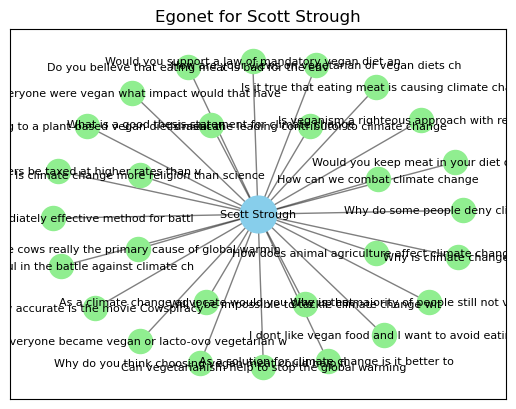

In [23]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load JSON data
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

# Initialize Counter to keep track of authors
author_counter = Counter()

# Count authors in the dataset
for item in data:
    for question, answers in item.items():
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            author_counter[author] += 1

# Get the most common author
top_author = author_counter.most_common(1)[0][0]

# Initialize NetworkX graph
G = nx.Graph()

# Add nodes and edges to the graph
for item in data:
    for question, answers in item.items():
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            G.add_node(author, type='author')
            G.add_node(question, type='question')
            G.add_edge(author, question)

# Get the egonet for the top author
radius = 1  # This means we're looking at the immediate neighbors of the ego
egonet = nx.ego_graph(G, top_author, radius=radius)

# Create a layout for the nodes
pos = nx.kamada_kawai_layout(egonet)

# Draw nodes
nx.draw_networkx_nodes(egonet, pos, nodelist=[n for n in egonet.nodes if egonet.nodes[n]['type'] == 'author'], node_color='skyblue', node_size=700)
nx.draw_networkx_nodes(egonet, pos, nodelist=[n for n in egonet.nodes if egonet.nodes[n]['type'] == 'question'], node_color='lightgreen', node_size=300)

# Draw edges
nx.draw_networkx_edges(egonet, pos, width=1.0, alpha=0.5)

# Draw labels for nodes
labels = {n: n for n in egonet.nodes}
nx.draw_networkx_labels(egonet, pos, labels=labels, font_size=8)

plt.title(f"Egonet for {top_author}")
plt.show()


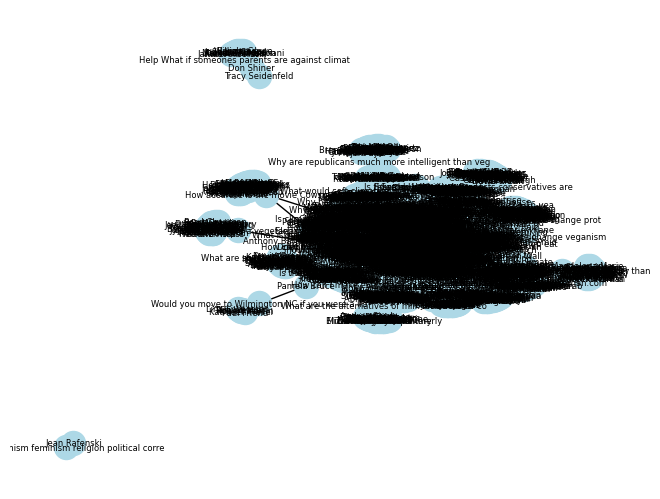

In [17]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load the JSON data from cleaned-QuoraforNetwork.json
with open("cleaned-QuoraforNetwork.json", "r") as file:
    data = json.load(file)

G = nx.Graph()

# Iterate over each question and its answers to add edges
for item in data:
    for question, answers in item.items():
        for answer_data in answers:
            author = answer_data.get("Author", "Unknown")
            G.add_edge(question, author)

# Draw the graph
nx.draw(G, with_labels=True, node_color="lightblue", font_size=6)
plt.show()

# Export the graph to GEXF format for Gephi
nx.write_gexf(G, "cleaned-QuoraforNetwork.gexf")


In [1]:
import networkx as nx
import json

# 1. Parse the JSON structure
with open('cleaned-QuoraforNetwork.json', 'r') as file:
    data = json.load(file)

G = nx.DiGraph()

for entry in data:
    question = list(entry.keys())[0]
    G.add_node(question, type='question')
    
    for response in entry[question]:
        author = response['Author']
        G.add_node(author, type='author')
        G.add_edge(question, author)

# 2. Statistics and Facts
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")

# Question with the Most Responses
questions = [node for node, attr in G.nodes(data=True) if attr['type'] == 'question']
question_degrees = [(question, G.out_degree(question)) for question in questions]
max_responses_question, max_responses = max(question_degrees, key=lambda x: x[1])
print(f"Question with the most responses: '{max_responses_question}' with {max_responses} responses.")

# Node with the Highest Degree Centrality
degree_centrality = nx.degree_centrality(G)
max_degree_node = max(degree_centrality, key=degree_centrality.get)
print(f"Node with the highest degree centrality: '{max_degree_node}'")

# Node with the Highest Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
print(f"Node with the highest betweenness centrality: '{max_betweenness_node}'")

# 3. Export for Gephi
nx.write_gexf(G, "quora_network.gexf")


Number of Nodes: 1602
Number of Edges: 2618
Question with the most responses: 'How can I make everybody in the world go vegan and' with 72 responses.
Node with the highest degree centrality: 'How can I make everybody in the world go vegan and'
Node with the highest betweenness centrality: 'Are vegans making an impact on climate change'


In [12]:
import networkx as nx
import json

# 1. Parse the JSON structure
with open('cleaned-QuoraforNetwork.json', 'r') as file:
    data = json.load(file)

G = nx.Graph()  # Using an undirected graph as we're connecting questions

author_to_questions = {}

# Map authors to the questions they've answered
for entry in data:
    question = list(entry.keys())[0]
    for response in entry[question]:
        author = response['Author']
        if author not in author_to_questions:
            author_to_questions[author] = []
        author_to_questions[author].append(question)

# 2. Add nodes and edges for questions with common authors
for author, questions in author_to_questions.items():
    if len(questions) > 1:  # Only consider authors who've answered more than one question
        for i in range(len(questions)):
            for j in range(i+1, len(questions)):
                # If there's no edge yet, add one
                if not G.has_edge(questions[i], questions[j]):
                    G.add_edge(questions[i], questions[j])

# 3. Export for Gephi
nx.write_gexf(G, "common_authors_network_undirected.gexf")

# 1. Basic Statistics
print(f"Number of Nodes (Questions): {G.number_of_nodes()}")
print(f"Number of Edges (Connections between questions with common authors): {G.number_of_edges()}")

# 2. Centrality Measures
degree_centrality = nx.degree_centrality(G)
max_degree_question = max(degree_centrality, key=degree_centrality.get)
print(f"Question with highest degree centrality: '{max_degree_question}' with a centrality of {degree_centrality[max_degree_question]:.2f}")

# Betweenness centrality can be computationally intensive for large graphs.
# So, if the graph is too large, you might want to skip this or use an approximation.
betweenness_centrality = nx.betweenness_centrality(G)
max_betweenness_question = max(betweenness_centrality, key=betweenness_centrality.get)
print(f"Question with highest betweenness centrality: '{max_betweenness_question}' with a centrality of {betweenness_centrality[max_betweenness_question]:.2f}")

# 3. Graph Properties
connected_components = [c for c in nx.connected_components(G)]
largest_connected_component = max(connected_components, key=len)
print(f"Number of Connected Components: {len(connected_components)}")
print(f"Size of Largest Connected Component: {len(largest_connected_component)}")

# Diameter can be computationally intensive for large connected components. 
# Ensure the component isn't too large before computing its diameter.
if len(largest_connected_component) < 1000:  # just an arbitrary threshold, adjust as needed
    print(f"Diameter of Largest Connected Component: {nx.diameter(G.subgraph(largest_connected_component))}")
else:
    print("Largest Connected Component is too large to compute its diameter.")

# Compute Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sort nodes based on their eigenvector centrality values and get the top 3
top_3_eigenvector_questions = sorted(eigenvector_centrality.keys(), key=lambda x: eigenvector_centrality[x], reverse=True)[:3]

print("\nTop 3 Questions based on Eigenvector Centrality:")
for idx, question in enumerate(top_3_eigenvector_questions, 1):
    print(f"{idx}. '{question}' with eigenvector centrality of {eigenvector_centrality[question]:.5f}")


Number of Nodes (Questions): 70
Number of Edges (Connections between questions with common authors): 1502
Question with highest degree centrality: 'Would you keep meat in your diet or bet on climate' with a centrality of 0.91
Question with highest betweenness centrality: 'Why do liberals think banning meat  dairy by 2050' with a centrality of 0.03
Number of Connected Components: 1
Size of Largest Connected Component: 70
Diameter of Largest Connected Component: 4

Top 3 Questions based on Eigenvector Centrality:
1. 'Would you keep meat in your diet or bet on climate' with eigenvector centrality of 0.15708
2. 'Do you believe that eating meat is bad for the env' with eigenvector centrality of 0.15277
3. 'Is it true that eating meat is causing climate cha' with eigenvector centrality of 0.15227


In [11]:

import networkx as nx
import json

# 1. Parse the JSON structure
with open('cleaned-QuoraforNetwork.json', 'r') as file:
    data = json.load(file)

# Create a directed graph
G = nx.DiGraph()

# Helper dictionary to keep track of authors and the questions they've answered
author_to_questions = {}

for entry in data:
    question = list(entry.keys())[0]
    
    for response in entry[question]:
        author = response['Author']
        
        # Add to the author's list of answered questions
        if author in author_to_questions:
            author_to_questions[author].append(question)
        else:
            author_to_questions[author] = [question]

# Filter out authors who've answered more than one question
common_authors = {author: questions for author, questions in author_to_questions.items() if len(questions) > 1}

# Add nodes and edges to the graph
for author, questions in common_authors.items():
    G.add_node(author, type='author')
    
    for question in questions:
        if not G.has_node(question):
            G.add_node(question, type='question')
        
        G.add_edge(author, question)

# Export for Gephi
nx.write_gexf(G, "common_authors_network_directed.gexf")

# ... [your code above]

# 1. Basic Statistics
print(f"Total Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Author Nodes: {sum(1 for _, attr in G.nodes(data=True) if attr['type'] == 'author')}")
print(f"Number of Question Nodes: {sum(1 for _, attr in G.nodes(data=True) if attr['type'] == 'question')}")
print(f"Total Number of Edges (Author-to-Question connections): {G.number_of_edges()}")

# 2. Centrality Measures
degree_centrality = nx.degree_centrality(G)
max_degree_node = max(degree_centrality, key=degree_centrality.get)
print(f"Node with highest degree centrality: '{max_degree_node}' with a centrality of {degree_centrality[max_degree_node]:.2f}")

# Note: Betweenness centrality can be computationally intensive for large graphs.
# If the graph is too large, you might consider skipping this or using an approximation.
betweenness_centrality = nx.betweenness_centrality(G)
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
print(f"Node with highest betweenness centrality: '{max_betweenness_node}' with a centrality of {betweenness_centrality[max_betweenness_node]:.2f}")

# 3. Graph Properties
strongly_connected_components = [c for c in nx.strongly_connected_components(G)]
weakly_connected_components = [c for c in nx.weakly_connected_components(G)]

print(f"Number of Strongly Connected Components: {len(strongly_connected_components)}")
print(f"Number of Weakly Connected Components: {len(weakly_connected_components)}")
print(f"Size of Largest Strongly Connected Component: {len(max(strongly_connected_components, key=len))}")
print(f"Size of Largest Weakly Connected Component: {len(max(weakly_connected_components, key=len))}")

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)

# Filter out only the question nodes from the results
question_centrality = {node: centrality for node, centrality in eigenvector_centrality.items() if G.nodes[node]['type'] == 'question'}

# Sort the questions based on eigenvector centrality and get the top 3
top_3_questions = sorted(question_centrality.keys(), key=lambda x: question_centrality[x], reverse=True)[:3]

print("Top 3 Questions based on Eigenvector Centrality:")
for idx, question in enumerate(top_3_questions, 1):
    print(f"{idx}. '{question}' with eigenvector centrality of {question_centrality[question]:.5f}")


Total Number of Nodes: 397
Number of Author Nodes: 327
Number of Question Nodes: 70
Total Number of Edges (Author-to-Question connections): 1424
Node with highest degree centrality: 'Why is climate change bad' with a centrality of 0.10
Node with highest betweenness centrality: 'Rupert McCallum' with a centrality of 0.00
Number of Strongly Connected Components: 397
Number of Weakly Connected Components: 1
Size of Largest Strongly Connected Component: 1
Size of Largest Weakly Connected Component: 397
Top 3 Questions based on Eigenvector Centrality:
1. 'Why is climate change bad' with eigenvector centrality of 0.21327
2. 'Why is the majority of people still not vegan desp' with eigenvector centrality of 0.19767
3. 'Is it true that eating meat is causing climate cha' with eigenvector centrality of 0.19247


Number of nodes (questions + authors): 1593
Number of edges (answers): 2618
Number of distinct authors: 1204
Number of distinct questions: 389
The most common number of answers for a question is: 1 with 1204 questions having this count.
The question with the highest number of answers has 72 answers.


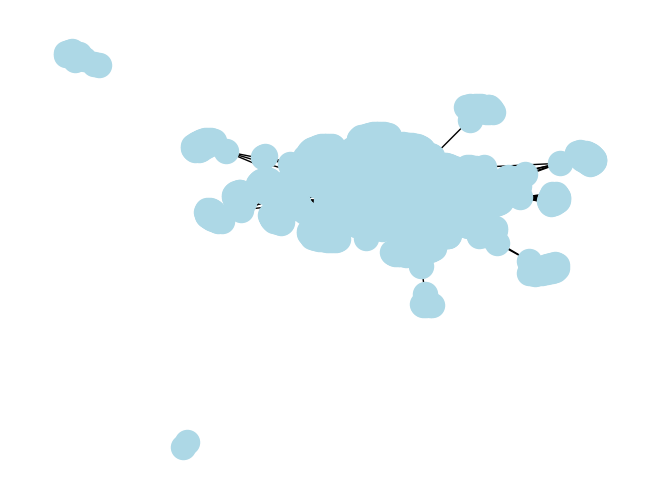

In [18]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load the JSON file
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

G = nx.Graph()

# Adjusted for the cleaned-QuoraforNetwork.json structure
for item in data:
    for question, answers in item.items():
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            G.add_edge(question, author)

# Basic Statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_authors = sum(1 for node in G.nodes() if G.degree(node) == 1)  # Assuming authors answer only one question
num_questions = num_nodes - num_authors

print(f"Number of nodes (questions + authors): {num_nodes}")
print(f"Number of edges (answers): {num_edges}")
print(f"Number of distinct authors: {num_authors}")
print(f"Number of distinct questions: {num_questions}")

# Interesting Observations
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = Counter(degree_sequence)
most_common_degree = degree_count.most_common(1)[0]

print(f"The most common number of answers for a question is: {most_common_degree[0]} with {most_common_degree[1]} questions having this count.")
print(f"The question with the highest number of answers has {max(degree_sequence)} answers.")

# Display the graph
nx.draw(G, with_labels=False, node_color="lightblue", font_size=6)
plt.show()


Enter a number between 1 and 81:  6


Displaying graph for question: 'What do vegans believe about climate change'


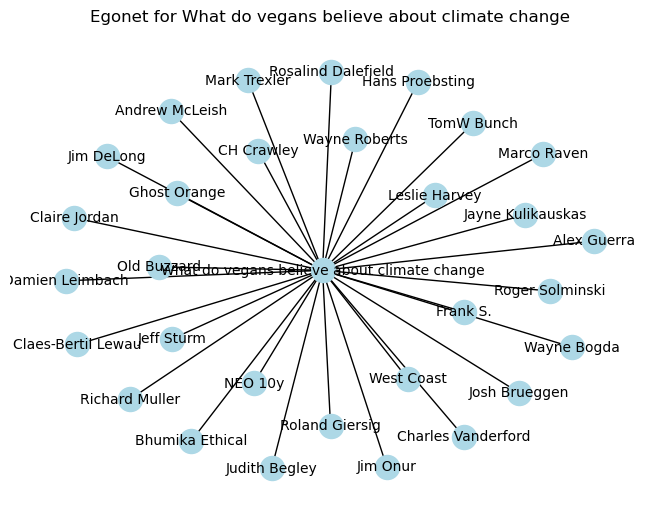

In [8]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load JSON data
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

# Initialize a dictionary to hold individual graphs for each question
graphs = {}

# Create separate graphs for each question
for item in data:
    for question, answers in item.items():
        # Initialize a new NetworkX graph for this question
        G = nx.Graph()
        
        # Add the question as a node
        G.add_node(question, type='question')
        
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            
            # Add the author as a node
            G.add_node(author, type='author')
            
            # Add an edge between the question and the author
            G.add_edge(question, author)
        
        # Store the graph in the dictionary
        graphs[question] = G

# Prompt the user to enter a number
num = int(input(f"Enter a number between 1 and {len(graphs)}: "))

# Use the entered number to select the corresponding question in order
selected_question = list(graphs.keys())[num-1]
print(f"Displaying graph for question: '{selected_question}'")

nx.draw(graphs[selected_question], with_labels=True, node_color='lightblue', font_size=10)
plt.title(f"Egonet for {selected_question}")
plt.show()


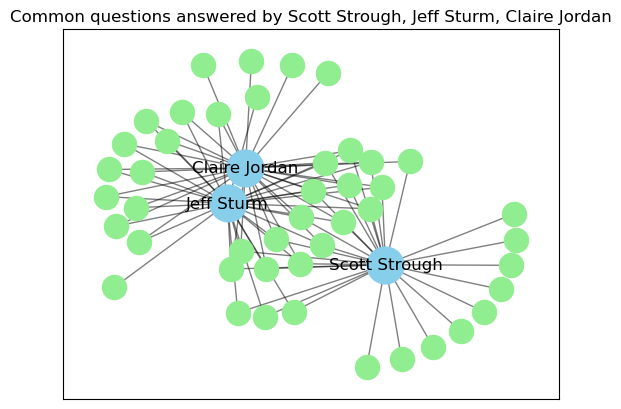

Number of nodes: 48
Number of edges: 90
Average degree: 3.75
Number of connected components: 1
Density: 0.08

Centrality measures for Scott Strough:
Degree Centrality: 0.60
Betweenness Centrality: 0.42

Centrality measures for Jeff Sturm:
Degree Centrality: 0.66
Betweenness Centrality: 0.33

Centrality measures for Claire Jordan:
Degree Centrality: 0.66
Betweenness Centrality: 0.37

Scott Strough answered 28 questions.

Jeff Sturm answered 31 questions.

Claire Jordan answered 31 questions.

Number of answers both Scott Strough and Jeff Sturm have in common: 18
Number of answers both Jeff Sturm and Claire Jordan have in common: 26
Number of answers both Scott Strough and Claire Jordan have in common: 16

Number of questions answered by all three authors (Scott Strough, Jeff Sturm, and Claire Jordan): 15

Questions answered by all three authors:
How can we combat climate change
Would you support a law of mandatory vegan diet an
Is meat the leading contributor to climate change 
Is the m

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load JSON data
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

# Initialize Counter to keep track of authors
author_counter = Counter()

# Count authors in the dataset
for item in data:
    for question, answers in item.items():
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            author_counter[author] += 1

# Get top 3 authors
top_3_authors = [author for author, _ in author_counter.most_common(3)]

# Initialize NetworkX graph
G = nx.Graph()

# Add nodes and edges to the graph
for item in data:
    for question, answers in item.items():
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            if author in top_3_authors:
                G.add_node(author, type='author')
                G.add_node(question, type='question')
                G.add_edge(author, question)

# Create a layout for the nodes
pos = nx.kamada_kawai_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'author'], node_color='skyblue', node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'question'], node_color='lightgreen', node_size=300)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw labels for authors
author_labels = {n: n for n in G.nodes if G.nodes[n]['type'] == 'author'}
nx.draw_networkx_labels(G, pos, labels=author_labels)

plt.title(f"Common questions answered by {top_3_authors[0]}, {top_3_authors[1]}, {top_3_authors[2]}")
plt.show()


# 1. Number of Nodes and Edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

# 2. Average Degree
avg_degree = sum(dict(G.degree()).values()) / num_nodes
print(f"Average degree: {avg_degree:.2f}")

# 3. Connected Components
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# 4. Density
density = nx.density(G)
print(f"Density: {density:.2f}")

# 5. Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

for author in top_3_authors:
    print(f"\nCentrality measures for {author}:")
    print(f"Degree Centrality: {degree_centrality[author]:.2f}")
    print(f"Betweenness Centrality: {betweenness_centrality[author]:.2f}")

# 6. Number of Questions Answered by Each Top Author
for author in top_3_authors:
    questions_answered = list(G.neighbors(author))
    print(f"\n{author} answered {len(questions_answered)} questions.")

    
# Find questions answered by both the top 2 authors by their names
author1 = top_3_authors[0]
author2 = top_3_authors[1]
author3 = top_3_authors[2]

common_answers_author1_author2 = set(G.neighbors(author1)) & set(G.neighbors(author2))
print(f"\nNumber of answers both {author1} and {author2} have in common: {len(common_answers_author1_author2)}")

common_answers_author2_author3 = set(G.neighbors(author2)) & set(G.neighbors(author3))
print(f"Number of answers both {author2} and {author3} have in common: {len(common_answers_author2_author3)}")

common_answers_author1_author3 = set(G.neighbors(author1)) & set(G.neighbors(author3))
print(f"Number of answers both {author1} and {author3} have in common: {len(common_answers_author1_author3)}")

# Find questions answered by all three authors
shared_questions_all_three = set(G.neighbors(author1)) & set(G.neighbors(author2)) & set(G.neighbors(author3))
print(f"\nNumber of questions answered by all three authors ({author1}, {author2}, and {author3}): {len(shared_questions_all_three)}")

# If you want to print the shared questions as well:
print("\nQuestions answered by all three authors:")
for question in shared_questions_all_three:
    print(question)

# If you want to print the common answers as well:
print(f"\nCommon questions answered by both {author1} and {author2}:")
for question in common_answers_author1_author2:
    print(question)

print(f"\nCommon questions answered by both {author2} and {author3}:")
for question in common_answers_author2_author3:
    print(question)

print(f"\nCommon questions answered by both {author1} and {author3}:")
for question in common_answers_author1_author3:
    print(question)

    

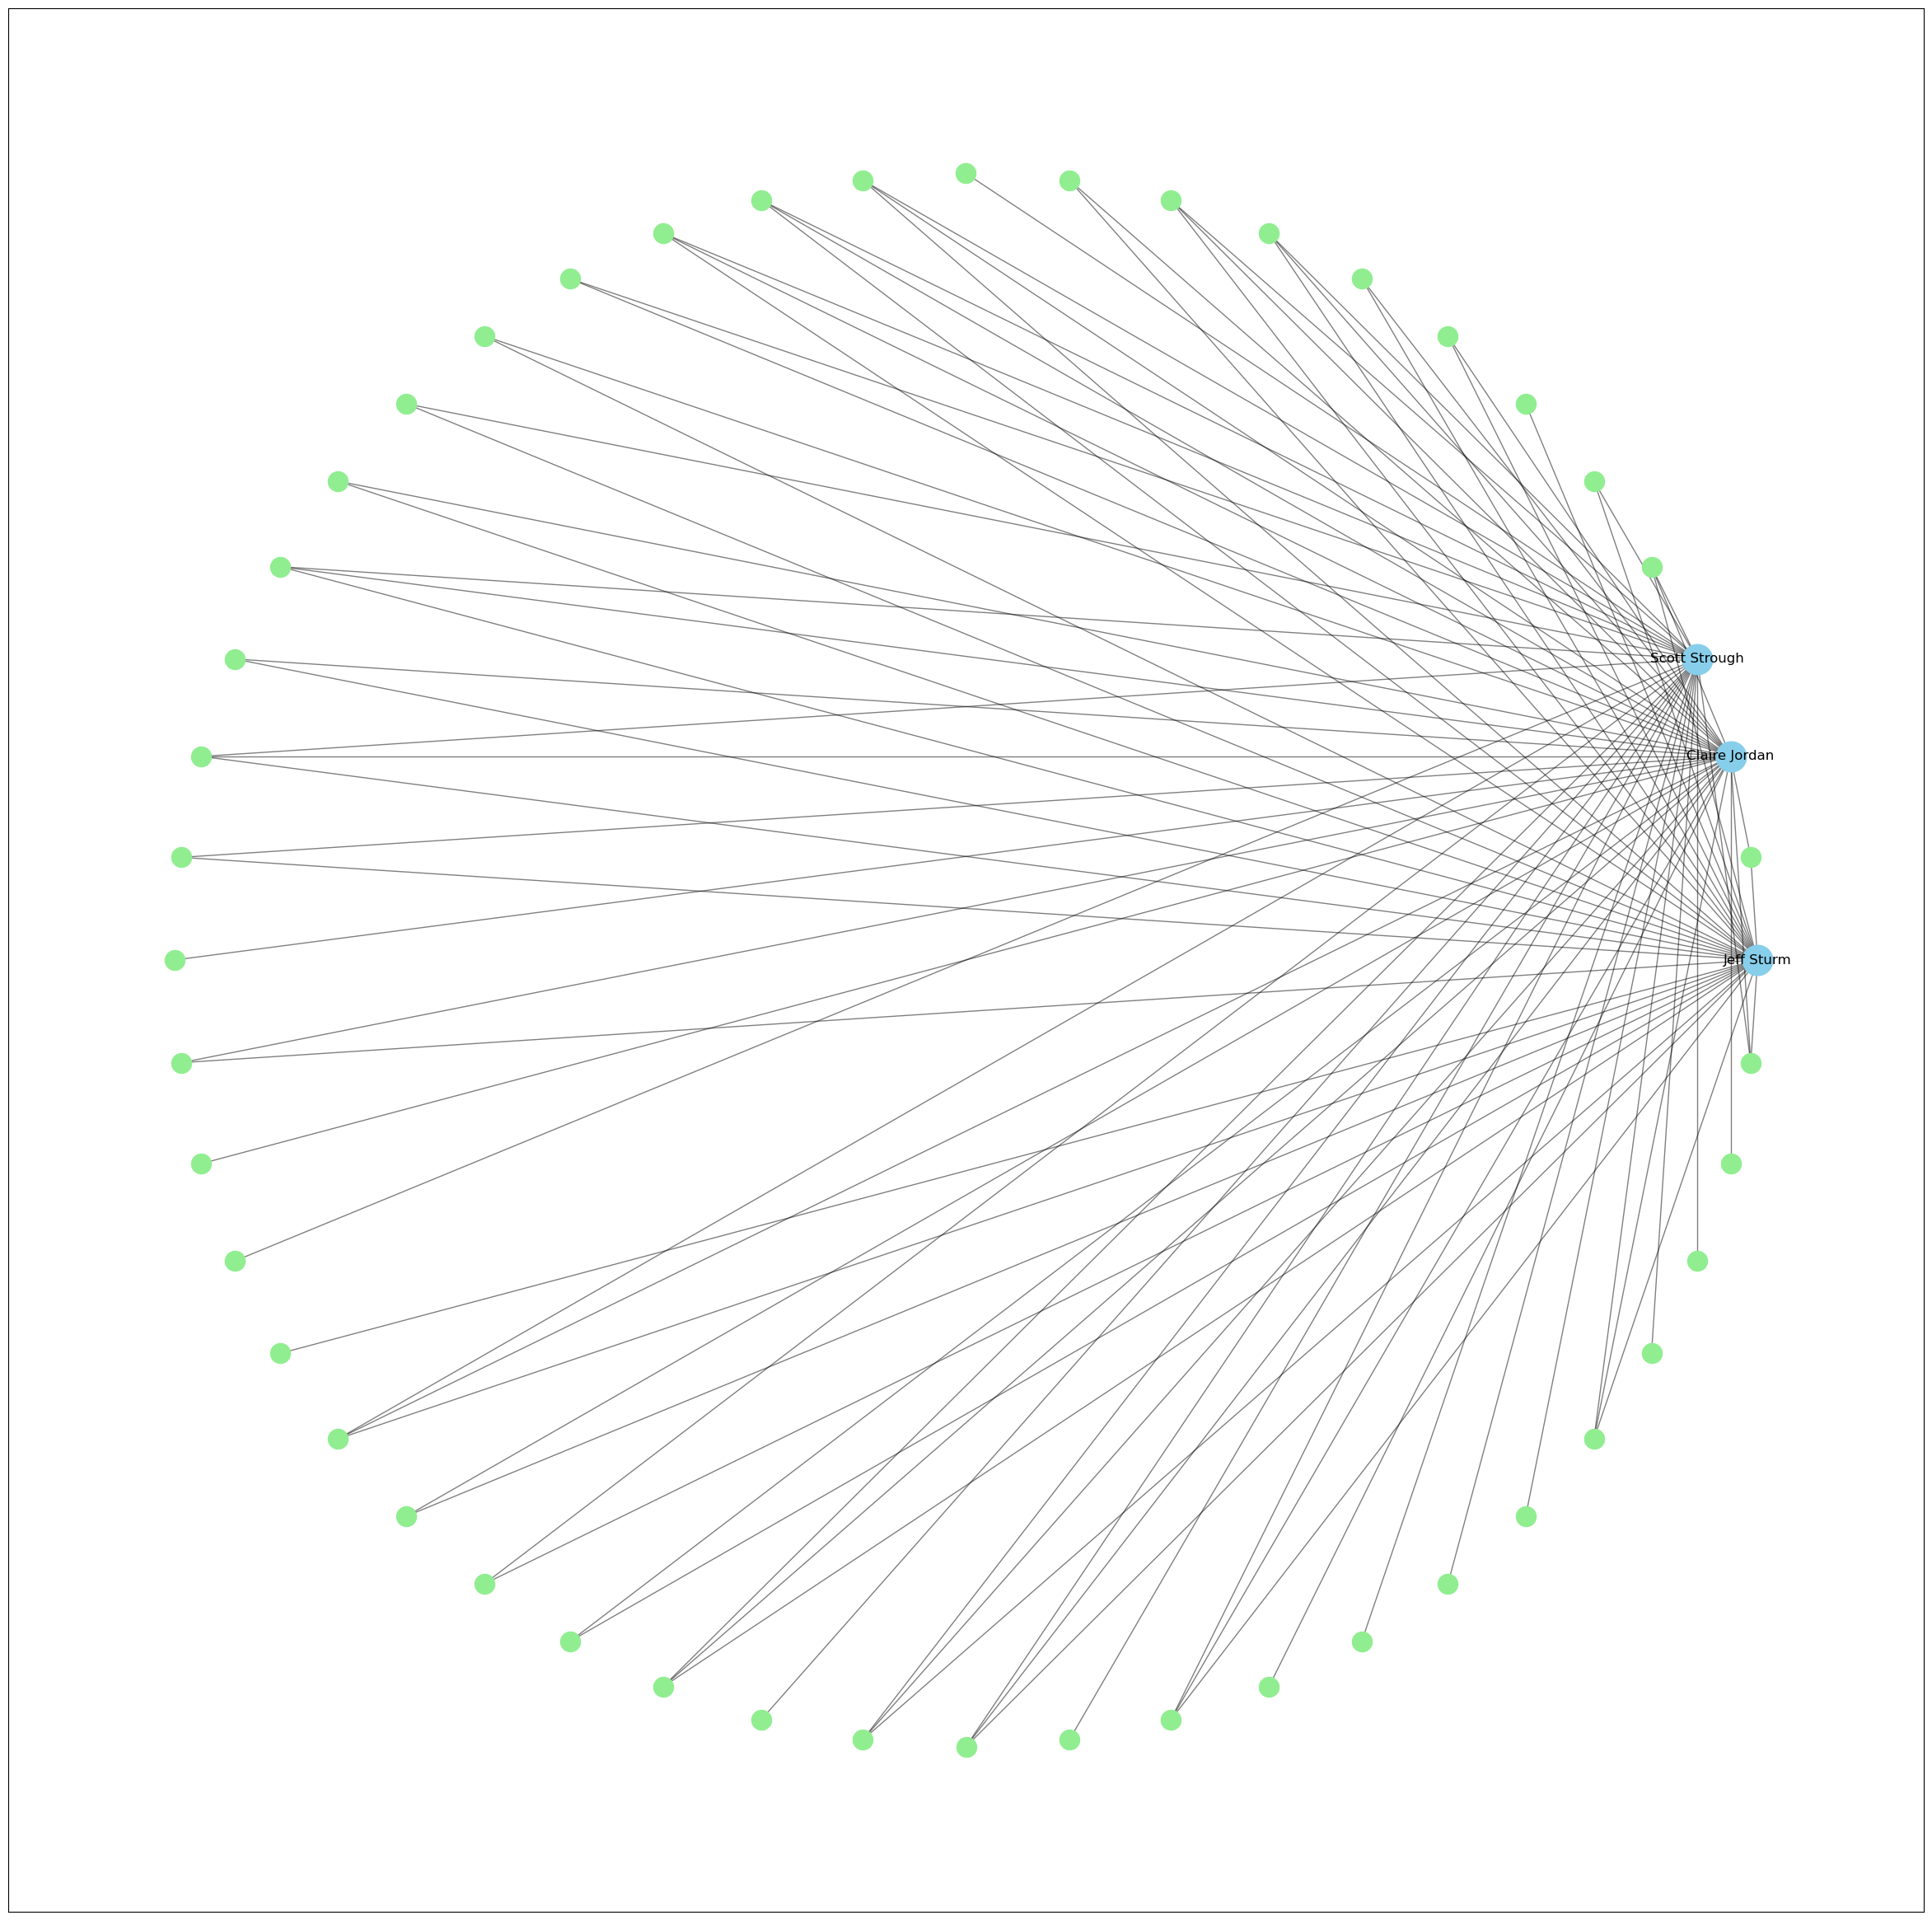

Number of nodes: 48
Number of edges: 90
Average degree: 3.75
Number of connected components: 1
Density: 0.08

Centrality measures for Scott Strough:
Degree Centrality: 0.60
Betweenness Centrality: 0.42

Centrality measures for Jeff Sturm:
Degree Centrality: 0.66
Betweenness Centrality: 0.33

Centrality measures for Claire Jordan:
Degree Centrality: 0.66
Betweenness Centrality: 0.37

Scott Strough answered 28 questions.

Jeff Sturm answered 31 questions.

Claire Jordan answered 31 questions.


In [2]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load JSON data
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

# Initialize Counter to keep track of authors
author_counter = Counter()

# Count authors in the dataset
for item in data:
    for question, answers in item.items():
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            author_counter[author] += 1

# Get top 3 authors
top_3_authors = [author for author, _ in author_counter.most_common(3)]

# Initialize NetworkX graph
G = nx.Graph()

# Add nodes and edges to the graph
for item in data:
    for question, answers in item.items():
        for answer_details in answers:
            author = answer_details.get('Author', 'Unknown')
            if author in top_3_authors:
                G.add_node(author, type='author')
                G.add_node(question, type='question')
                G.add_edge(author, question)

# Set the figure size
plt.figure(figsize=(30, 30))
# Create a layout for the nodes
pos = nx.circular_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'author'], node_color='skyblue', node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'question'], node_color='lightgreen', node_size=300)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw labels for authors
author_labels = {n: n for n in G.nodes if G.nodes[n]['type'] == 'author'}
nx.draw_networkx_labels(G, pos, labels=author_labels)

plt.show()


# 1. Number of Nodes and Edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

# 2. Average Degree
avg_degree = sum(dict(G.degree()).values()) / num_nodes
print(f"Average degree: {avg_degree:.2f}")

# 3. Connected Components
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# 4. Density
density = nx.density(G)
print(f"Density: {density:.2f}")

# 5. Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

for author in top_3_authors:
    print(f"\nCentrality measures for {author}:")
    print(f"Degree Centrality: {degree_centrality[author]:.2f}")
    print(f"Betweenness Centrality: {betweenness_centrality[author]:.2f}")

# 6. Number of Questions Answered by Each Top Author
for author in top_3_authors:
    questions_answered = list(G.neighbors(author))
    print(f"\n{author} answered {len(questions_answered)} questions.")


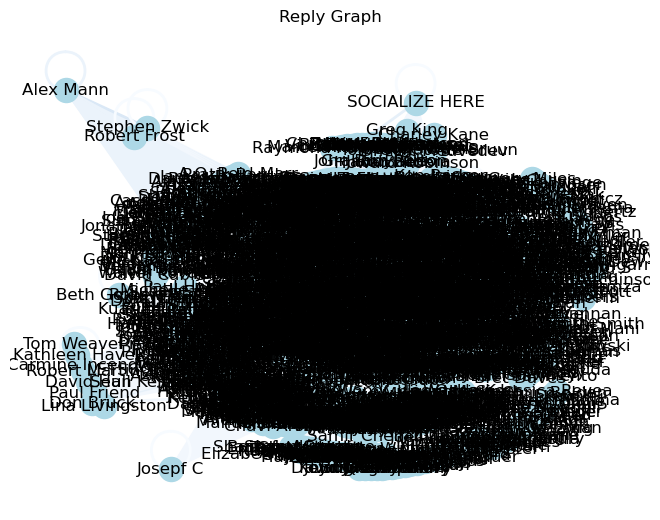

Graph has been saved to reply_graph.gexf. You can now open this file in Gephi.


In [28]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load JSON data
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

# Initialize the reply graph
G_reply = nx.Graph()

# Process the data to populate the reply graph
for item in data:
    for question, answers in item.items():
        authors = [answer['Author'] for answer in answers]
        # Add edges between all authors who answered the same question
        for i in range(len(authors)):
            for j in range(i+1, len(authors)):
                if G_reply.has_edge(authors[i], authors[j]):
                    # If the edge already exists, increase the weight
                    G_reply[authors[i]][authors[j]]['weight'] += 1
                else:
                    # Else, add a new edge with weight 1
                    G_reply.add_edge(authors[i], authors[j], weight=1)

# Visualization
pos = nx.kamada_kawai_layout(G_reply)
edge_weights = [G_reply[u][v]['weight'] for u, v in G_reply.edges()]

nx.draw(G_reply, pos, with_labels=True, node_color='lightblue', edge_color=edge_weights, edge_cmap=plt.cm.Blues, width=2)
plt.title("Reply Graph")
plt.show()

nx.write_gexf(G_reply, "reply_graph.gexf")

print("Graph has been saved to reply_graph.gexf. You can now open this file in Gephi.")

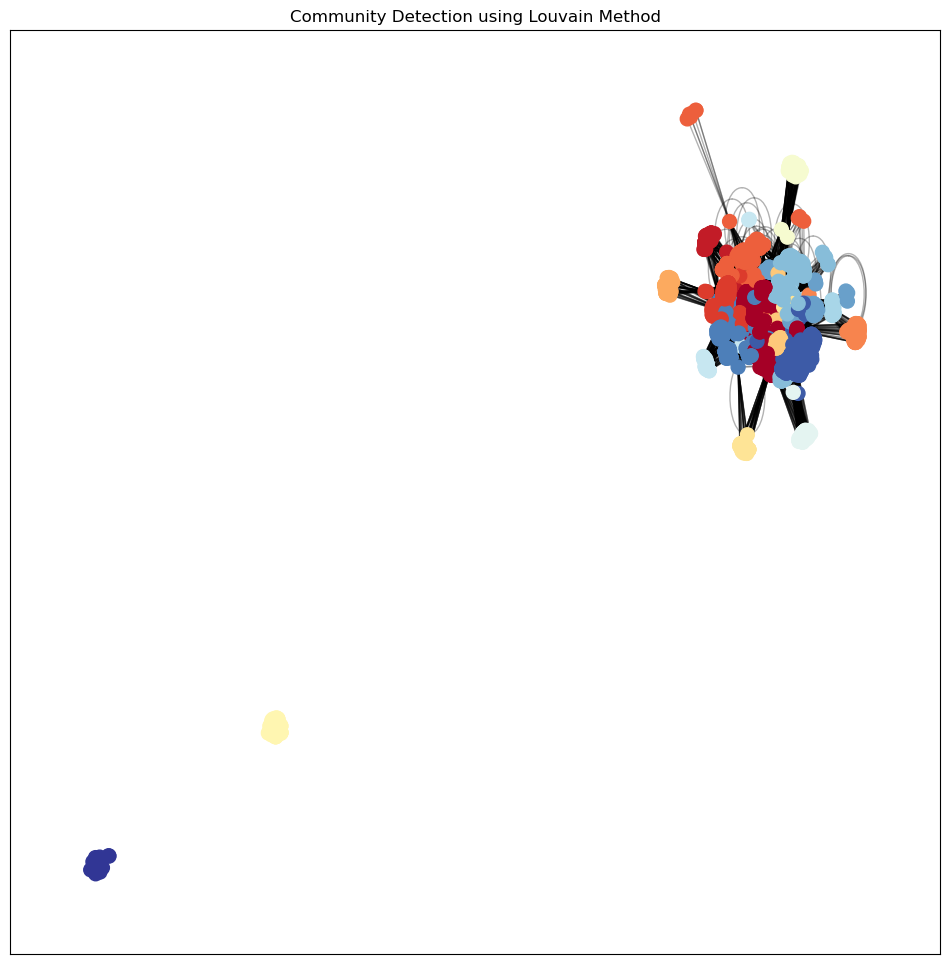

Graph has been saved to community_detection.gexf. You can now open this file in Gephi.
Number of nodes: 1519
Number of edges: 48013
Average degree: 63.22

Number of communities detected: 18
Size of community 1: 317
Size of community 2: 34
Size of community 3: 118
Size of community 4: 98
Size of community 5: 43
Size of community 6: 31
Size of community 7: 39
Size of community 8: 76
Size of community 9: 31
Size of community 10: 38
Size of community 11: 39
Size of community 12: 28
Size of community 13: 49
Size of community 14: 148
Size of community 15: 68
Size of community 16: 141
Size of community 17: 210
Size of community 18: 11

Top 5 nodes by degree centrality:
Scott Strough: 0.4302
Claire Jordan: 0.3821
Jeff Sturm: 0.3551
Jayne Kulikauskas: 0.3274
Michael Barnard: 0.3274

Top 5 nodes by betweenness centrality:
Scott Strough: 0.1030
Claire Jordan: 0.0638
Donna Fernstrom: 0.0507
Michael Barnard: 0.0459
Jayne Kulikauskas: 0.0426

Top 5 nodes by closeness centrality:
Scott Strough: 0.622

In [17]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import community  # python-louvain

# Load JSON data
with open("cleaned-QuoraforNetwork.json", "r") as f:
    data = json.load(f)

# Create a graph from the data
G = nx.Graph()
for item in data:
    for question, answers in item.items():
        authors = [answer['Author'] for answer in answers]
        for i in range(len(authors)):
            for j in range(i+1, len(authors)):
                if G.has_edge(authors[i], authors[j]):
                    G[authors[i]][authors[j]]['weight'] += 1
                else:
                    G.add_edge(authors[i], authors[j], weight=1)

# Detect communities
partition = community.best_partition(G)

# Visualize the graph with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Community Detection using Louvain Method")
plt.show()

nx.write_gexf(G, "community_detection.gexf")


print("Graph has been saved to community_detection.gexf. You can now open this file in Gephi.")
# Basic Information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Average degree: {avg_degree:.2f}")

# Community Information
num_communities = len(set(partition.values()))
print(f"\nNumber of communities detected: {num_communities}")
community_sizes = [list(partition.values()).count(i) for i in range(num_communities)]
for i, size in enumerate(community_sizes):
    print(f"Size of community {i+1}: {size}")

# Centrality Measures (computing for the entire graph can be time-consuming for large graphs)
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Printing top 5 nodes by centrality measures
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 nodes by degree centrality:")
for node, value in top_degree:
    print(f"{node}: {value:.4f}")

print("\nTop 5 nodes by betweenness centrality:")
for node, value in top_betweenness:
    print(f"{node}: {value:.4f}")

print("\nTop 5 nodes by closeness centrality:")
for node, value in top_closeness:
    print(f"{node}: {value:.4f}")

# Other Measures
avg_clustering = nx.average_clustering(G)
print(f"\nAverage clustering coefficient: {avg_clustering:.4f}")
# diameter = nx.diameter(G)
# print(f"Diameter: {diameter}")


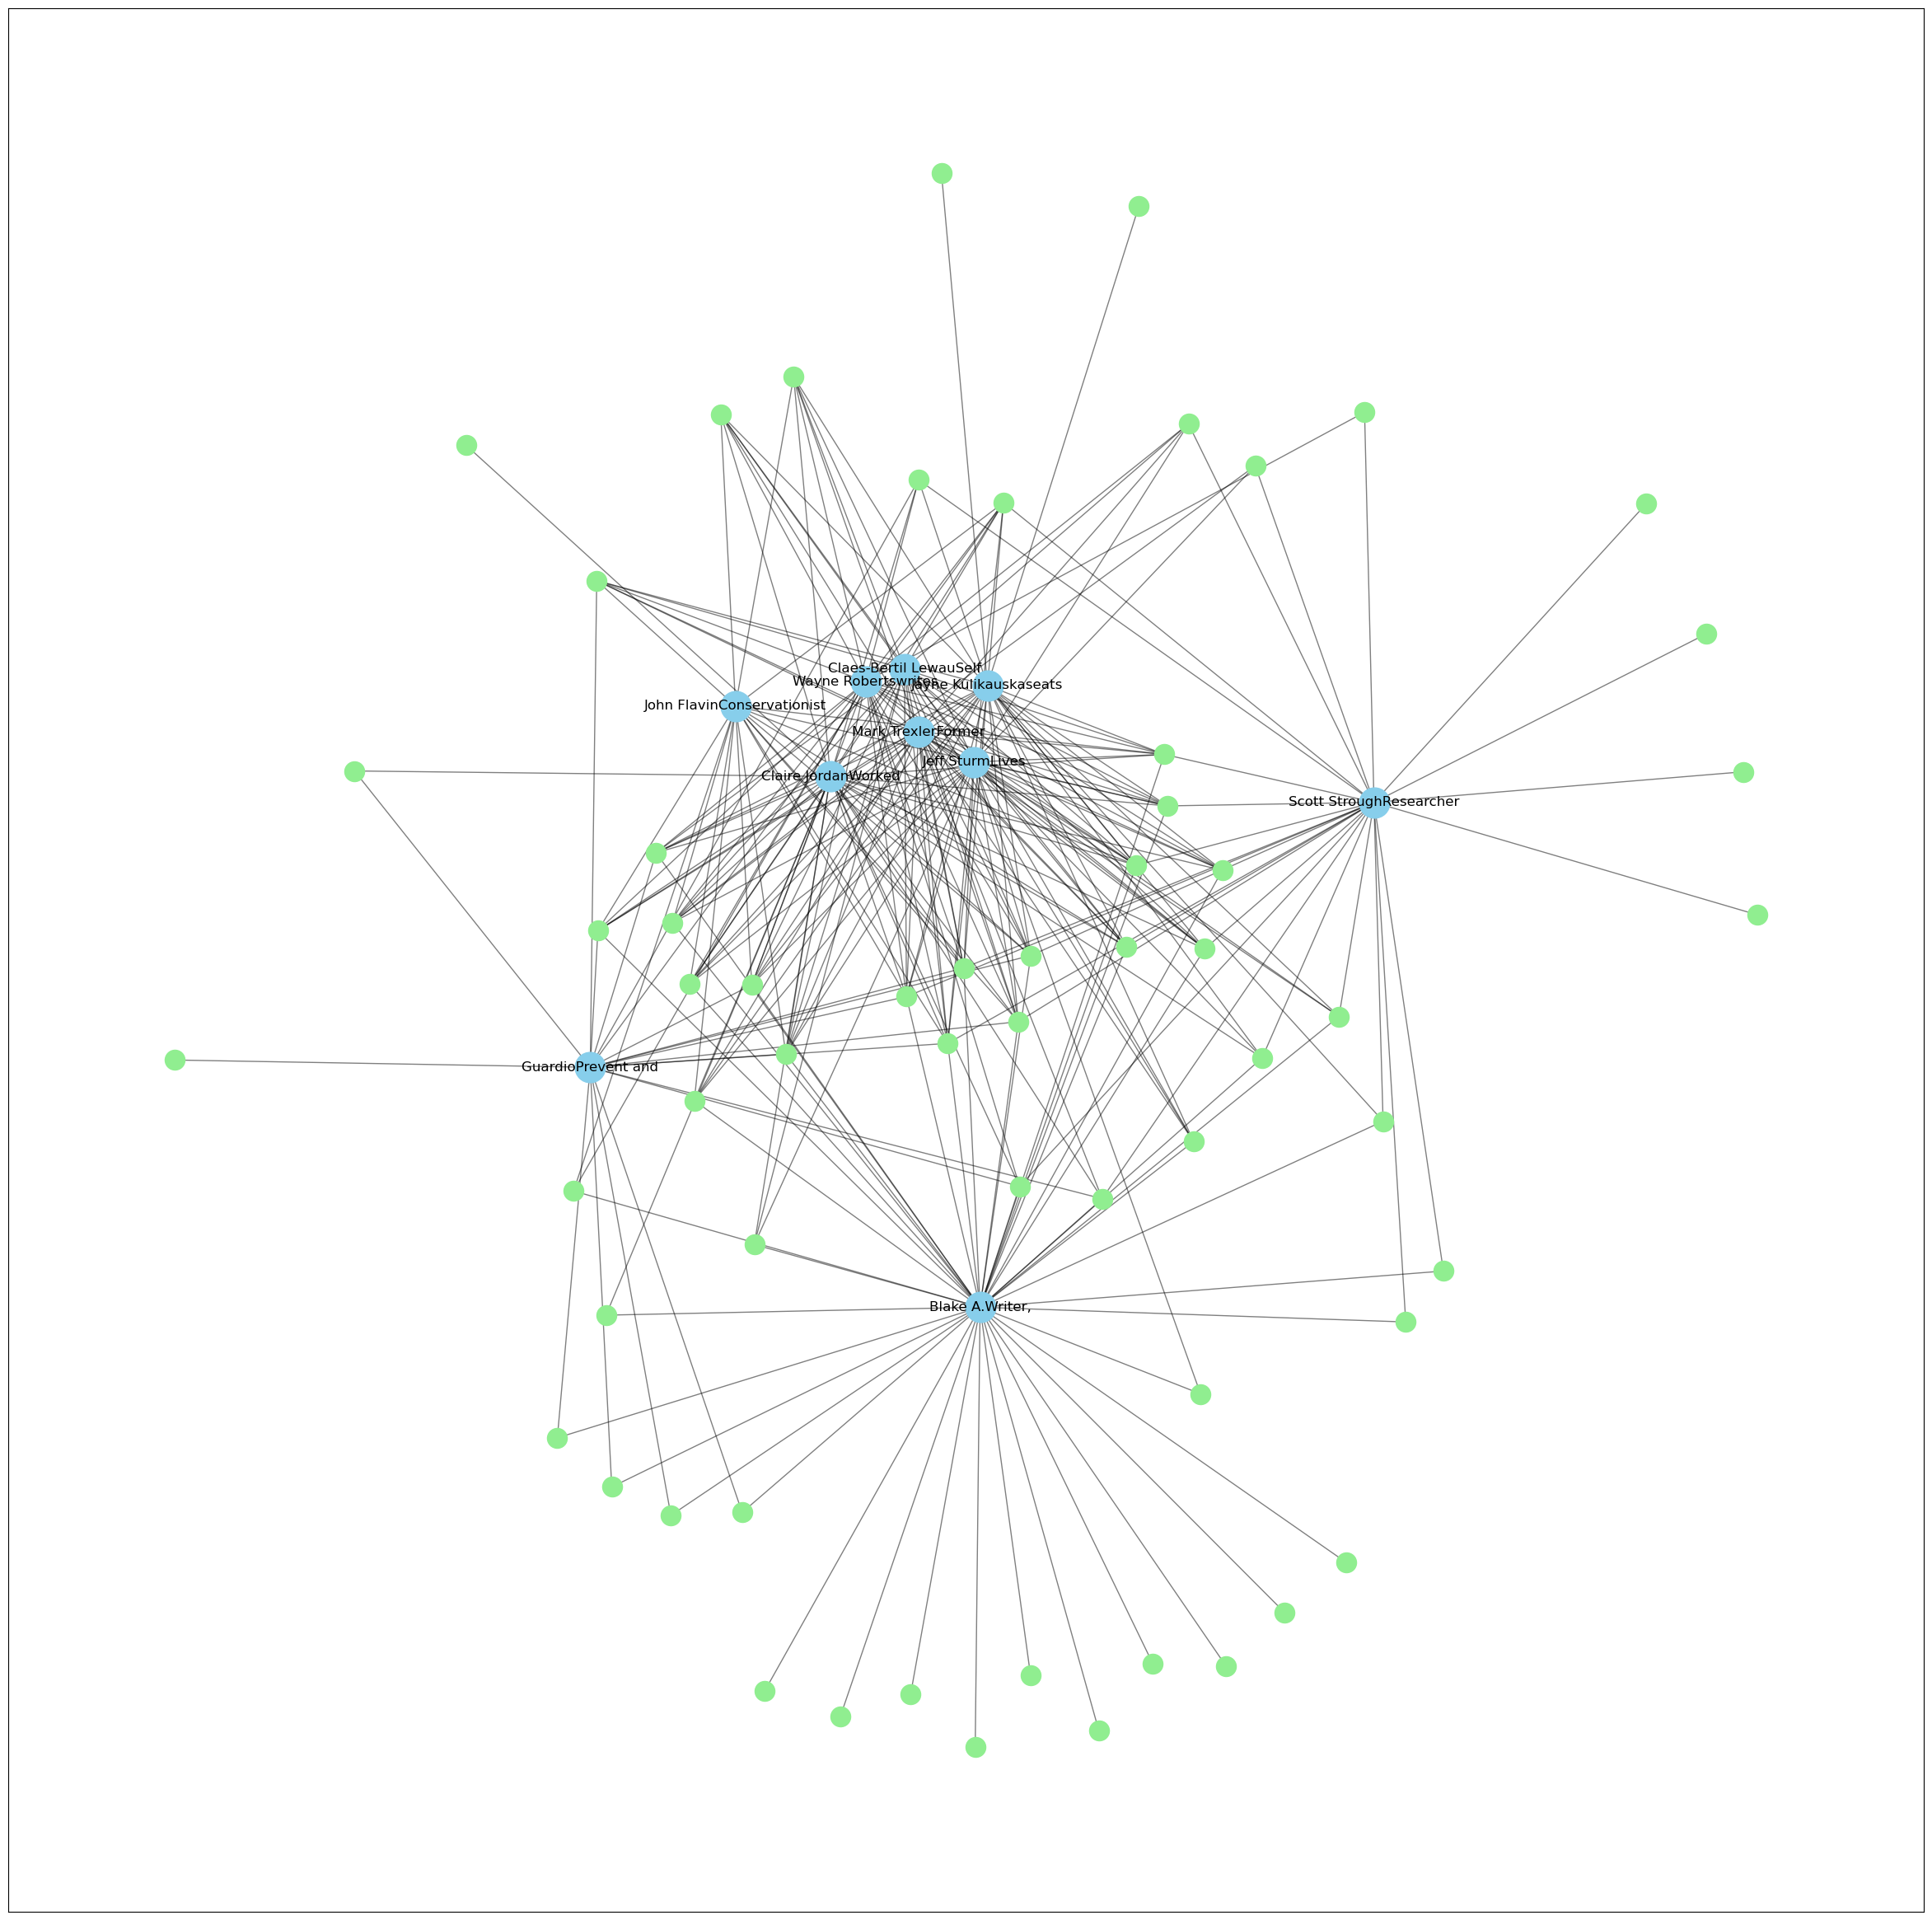

In [43]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load JSON data
with open("MegaQuora83.json", "r") as f:
    data = json.load(f)

# Initialize Counter to keep track of authors
author_counter = Counter()

# Count authors in the dataset
for question, info in data.items():
    for answer in info['answers']:
        author = answer.get('Author', 'Unknown')
        author_counter[author] += 1

# Get top 3 authors
top_3_authors = [author for author, _ in author_counter.most_common(10)]

# Initialize NetworkX graph
G = nx.Graph()

# Add nodes and edges to the graph
for question, info in data.items():
    for answer in info['answers']:
        author = answer.get('Author', 'Unknown')
        if author in top_3_authors:
            G.add_node(author, type='author')
            G.add_node(question, type='question')
            G.add_edge(author, question)


# Set the figure size
plt.figure(figsize=(30, 30))
            
            
# Create a layout for the nodes
pos = nx.kamada_kawai_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'author'], node_color='skyblue', node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes if G.nodes[n]['type'] == 'question'], node_color='lightgreen', node_size=300)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw labels for authors
author_labels = {n: n for n in G.nodes if G.nodes[n]['type'] == 'author'}
nx.draw_networkx_labels(G, pos, labels=author_labels)

plt.show()
